1. create conda env and activate
2. install 3.8.11 in conda env
3. install pip
4. install reqs

In [1]:
import sys
import os

sys.path.append(os.path.dirname(os.getcwd()))
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'ai8x-training')) #needed for ai8x module to be loaded
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'ai8x-synthesis')) #needed for ai8x module to be loaded
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'ai8x-training/models'))

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
from torchvision import transforms
from torchvision.io import read_image
import ai8x
from distiller import apputils
import pandas as pd
import matplotlib.pyplot as plt
import datasets.ims_bearings as ims_bearings
import numpy as np
from models import memenet
import parse_qat_yaml
from utils import parse_sampleoutput


def printstats(variable):
    print("Shape: ", variable.shape)
    print("Max: ", variable.max())
    print("Min: ", variable.min())
    print("Mean: ", variable.mean())
    print("Variance: ", variable.var())
    

def mahalanobis_distance(x, y):
    x = x.flatten()
    y = y.flatten()
    #x and y are 1d numpy arrays
    
    data = np.array([x,y]).T
    cov = np.cov(data) #Each row of data represents a variable, and each column a single observation of all those variables.
    inv_cov = np.linalg.inv(cov + 1e-5*np.eye(cov.shape[0])) #add small value to diagonal to prevent singularity
    diff = x-y
    
    return np.sqrt(np.dot(np.dot(diff,inv_cov),diff))
    
    

def infer(model, input_img):
    sample_input = input_img #expected quant input range -128 to 127/128
    sample_output_model = model(sample_input.unsqueeze(0)) #output range -1 to 1
    
    #feed input into layers 1 through 3, flatten 3, then output 4
    encoder = torch.nn.Sequential(*list(model.children())[:3], torch.nn.Flatten(), list(model.children())[3])
    z = encoder(sample_input.unsqueeze(0))
    
    sample_output = 255*(sample_output_model+1)/2 #output range 0 to 255

    in_img = sample_input.permute(1,2,0) #0-255
    out_img = sample_output.squeeze(0).permute(1,2,0) #0-255
    
    msel = torch.nn.MSELoss()
                   
    return in_img, out_img, np.round(msel(sample_input,sample_output_model).item(), 4), z


%matplotlib inline

Train set size:  6450
Test (only suspect for now) set size:  1645


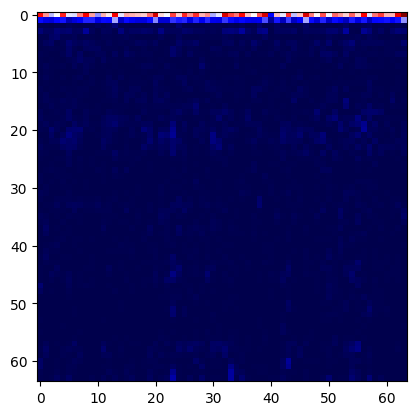

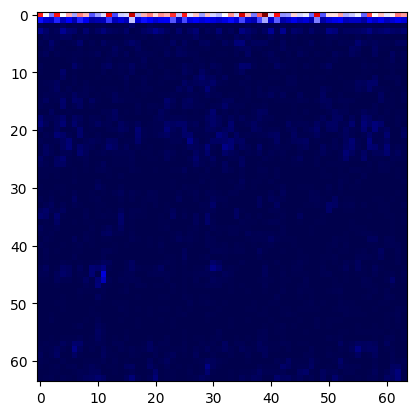

In [3]:
#Get OOD data

#check dataloader
class Args:
    def __init__(self, act_mode_8bit):
        self.act_mode_8bit = act_mode_8bit #IMPORTANT: SET CORRECTLY!!!!!!!!
        self.truncate_testset = False 

args = Args(act_mode_8bit=False) #IMPORTANT: if this is not set to true, the test set will be float instead of int, and so you can't use the quantized model
data_path = os.path.join(os.path.dirname(os.getcwd()), 'ai8x-training/data')

ds_train,ds_test = ims_bearings.ims_bearings_get_datasets((data_path, args), load_train=True, load_test=True)

print("Train set size: ", len(ds_train))
print("Test (only suspect for now) set size: ", len(ds_test))

plt.imshow(ds_train[1400][0].permute(1,2,0).numpy(), cmap='seismic')
plt.figure()
plt.imshow(ds_test[1400][0].permute(1,2,0).numpy(), cmap='seismic')

### Expected Data Range

For training, input data is expected to be in the range  . When evaluating quantized weights, or when running on hardware, input data is instead expected to be in the native MAX7800X range of [-128, +127].

As described in the following sections, the data loader function takes the data path and some arguments as input arguments. The arguments field includes two required fields, act_mode_8bit and truncate_testset. When set to True, the first argument refers to the case normalization should be done correctly for the native MAX7800X range, i.e., to range [-128, +127]. When set to False, the normalization should be in the range of  for training.

If the available data is in the range of [0 1], e.g., as in PIL images, the data loader can directly call the ai8x.normalize() function to normalize the data to the two supported data ranges using the provided args argument:

class normalize:
"""
Normalize input to either [-128/128, +127/128] or [-128, +127]
"""
    def __init__(self, args):
        self.args = args

    def __call__(self, img):
        if self.args.act_mode_8bit:
            return img.sub(0.5).mul(256.).round().clamp(min=-128, max=127)
        return img.sub(0.5).mul(256.).round().clamp(min=-128, max=127).div(128.)

If the available data range is [0 255], it needs to be divided by 256 to bring it to the [0 1] range before calling the ai8x.normalize() function.

Note: The device setting method ai8x.set_device of the ai8x module also accepts a related parameter simulate: True for the training case (act_mode_8bit = True) and False for the evaluation of quantized model or running on hardware that also initializes act_mode_8bit = False. This method is used by training scripts with proper argument management, but if one calls the function externally, the simulate parameter should be set correctly.

When running inference on the MAX7800X hardware, it is essential to take the native data format into account, and it is desirable to perform as little preprocessing as possible during inference.



# Test on non quant model

In [ ]:
#check dataloader
class Args:
    def __init__(self, act_mode_8bit):
        self.act_mode_8bit = act_mode_8bit #IMPORTANT: SET CORRECTLY!!!!!!!!
        self.truncate_testset = False 

args = Args(act_mode_8bit=False) #IMPORTANT: if this is not set to true, the test set will be float instead of int, and so you can't use the quantized model
data_path = os.path.join(os.path.dirname(os.getcwd()), 'ai8x-training/data')

ds_train,ds_test = memes.memes_get_datasets((data_path, args), load_train=True, load_test=True)

printstats(ds_train[2][1])

In [ ]:
#ai8x.set_device(85, True, True)  #IMPORTANT: SET SIMULATE PARAM, AS IT WILL OVERRIDE 8bit PARAM !!!!!!!! 
ai8x.set_device(85, False, False)  #use if non quant (ai8x.set_device(85, False, False) if not using -q file)

#The device setting method ai8x.set_device of the ai8x module also accepts a related parameter simulate: True for the training case (act_mode_8bit = True) and False for the evaluation of quantized model or running on hardware that also initializes act_mode_8bit = False. 

model = memenet.MemeNet(num_channels=1, dimensions=(16,16))
checkpoint_path = '../ai8x-synthesis/trained/qat_best.pth.tar'
model = apputils.load_lean_checkpoint(model, checkpoint_path)
ai8x.update_model(model)

#mean latent normal vector 
z_mean = np.array([0.9921875,  0.39765626, 0.69453126, 0.9921875,  0.1984375])

model.eval()
with torch.no_grad():
    
    sample_input2 = 255*(ood_img)-127 #convert PIL 0-1 to  input range -127 to 128
    in_img2, out_img2, mse, ood_z = infer(model, sample_input2)
    ood_z = ood_z.squeeze().numpy().astype(np.float32)
    
    fig2, ax2 = plt.subplots(1,2)
    ax2[0].imshow(in_img2)
    ax2[1].imshow(out_img2)
    ax2[0].set_title('OOD sample')
    ax2[0].set_title('OOD mse:%s, md_to_mean=%s'% (mse, mahalanobis_distance(ood_z,z_mean)))
    
    test_z=[]
    train_z=[]
    
    if True:
        #training set
        fig , ax= plt.subplots(10,2)
        fig.set_figheight(20)
        fig.set_figwidth(5)
        for i in range(10):
            idx=i
            sample_input = ds_train[idx][0] # input from -1 to 1 is expected
            in_img, out_img, mse, normal_z = infer(model, sample_input)
            
            normal_z = normal_z.squeeze().numpy().astype(np.float32)
            
            md_mean = np.round(mahalanobis_distance(normal_z,z_mean),4)
            
            train_z.append(normal_z)
            

            ax[i][0].imshow(in_img)
            ax[i][1].imshow(out_img)
            ax[i][0].axis('off')
            ax[i][1].axis('off')
            #title ax
            ax[i][0].set_title('Training sample')
            ax[i][1].set_title('MSE:%s, mdmean=%s'% (mse, md_mean))
            
    if True:
        #test set
        fig , ax= plt.subplots(10,2)
        fig.set_figheight(20)
        fig.set_figwidth(5)
        for i in range(10):
            idx=i
            sample_input = ds_test[idx][0] # input from -1 to 1 is expected
            in_img, out_img, mse, normal_z = infer(model, sample_input)
            
            normal_z = normal_z.squeeze().numpy().astype(np.float32)
            
            md_mean = np.round(mahalanobis_distance(normal_z,z_mean),4)
            
            test_z.append(normal_z)


            ax[i][0].imshow(in_img)
            ax[i][1].imshow(out_img)
            ax[i][0].axis('off')
            ax[i][1].axis('off')
            #title ax
            ax[i][0].set_title('Training sample')
            ax[i][1].set_title('MSE:%s, mdmean=%s'% (mse, md_mean))
        
    
    train_z = np.array(train_z)
    test_z = np.array(test_z)
    
    print("Mean distance to OOD sample in training set: ", np.mean([np.linalg.norm(normal_z-ood_z) for normal_z in train_z]))
    print("Mean distance to OOD sample in test set: ", np.mean([np.linalg.norm(normal_z-ood_z) for normal_z in test_z]))
    
    mean_train_z = np.mean(train_z, axis=0)
    print(mean_train_z)

### Test set evaluation of the quantized model

In [ ]:
#check dataloader
class Args:
    def __init__(self, act_mode_8bit):
        self.act_mode_8bit = act_mode_8bit #IMPORTANT: SET CORRECTLY!!!!!!!!
        self.truncate_testset = False 

args = Args(act_mode_8bit=True) #IMPORTANT: set to TRUE for quantization
data_path = os.path.join(os.path.dirname(os.getcwd()), 'ai8x-training/data')

ds_train,ds_test = memes.memes_get_datasets((data_path, args), load_train=True, load_test=True)

printstats(ds_train[2][1])

In [ ]:
#ai8x.set_device(85, True, True)  #IMPORTANT: SET SIMULATE PARAM, AS IT WILL OVERRIDE 8bit PARAM !!!!!!!! 
ai8x.set_device(85, True, True)  #use if quant

#The device setting method ai8x.set_device of the ai8x module also accepts a related parameter simulate: 
# True for the training case (act_mode_8bit = True) and False for the evaluation of quantized model or running on hardware that also initializes act_mode_8bit = False. 

model = memenet.MemeNet(num_channels=1, dimensions=(16,16))

# Switch model from unquantized to quantized for QAT
qat_yaml_file_used_in_training = '../ai8x-training/policies/qat_policy_memenet.yaml'
qat_policy = parse_qat_yaml.parse(qat_yaml_file_used_in_training)
ai8x.initiate_qat(model, qat_policy)


checkpoint_path = '../ai8x-synthesis/trained/qat_best-q.pth.tar'
model = apputils.load_lean_checkpoint(model, checkpoint_path)
ai8x.update_model(model)


model.eval()
with torch.no_grad():
    sample_input2 = 255*(ood_img)-127 #convert PIL 0-1 to  input range -127 to 128
    in_img2, out_img2, mse, z = infer(model, sample_input2)

    fig2, ax2 = plt.subplots(1,2)
    ax2[0].imshow(in_img2)
    ax2[1].imshow(out_img2)
    ax2[0].set_title('OOD sample')
    ax2[0].set_title('OOD mse:%s'% mse)
    
    if True:
        #training set
        fig , ax= plt.subplots(10,2)
        fig.set_figheight(20)
        fig.set_figwidth(5)
        for i in range(10):
            idx=i
            sample_input = ds_train[idx][0] #expected quant input range -128 to 127/128
            in_img, out_img, mse, z= infer(model, sample_input)
            
            ax[i][0].imshow(in_img)
            ax[i][1].imshow(out_img)
            ax[i][0].axis('off')
            ax[i][1].axis('off')
            #title ax
            ax[i][0].set_title('Training sample')
            ax[i][1].set_title('MSE:%s'%mse)
            
            
    if True:
        #test set
        fig , ax= plt.subplots(10,2)
        fig.set_figheight(20)
        fig.set_figwidth(5)
        for i in range(10):
            idx=i
            
            sample_input = ds_test[idx][0] #expected quant input range -128 to 127/128
            in_img, out_img, mse, z= infer(model, sample_input)
            
            ax[i][0].imshow(in_img)
            ax[i][1].imshow(out_img)
            ax[i][0].axis('off')
            ax[i][1].axis('off')
            #title ax
            ax[i][0].set_title('Training sample')
            ax[i][1].set_title('MSE:%s'%mse)

In [ ]:
num_weights = 0
num_bias = 0
for name, param in model.named_parameters():
    if param.requires_grad:
        if name.endswith('weight'):
            num_weights += np.prod(param.size())
        elif name.endswith('bias'):
            num_bias += np.prod(param.size())


print(f'Number of Model Weights: {num_weights}')
print(f'Number of Model Bias: {num_bias}\n')

In [ ]:
sampleoutput_h_file_path = '../ai8x-synthesis/synthed_net/memenet/sampleoutput.h'
sampleoutput_h_dict = parse_sampleoutput.parse_sampleoutput_to_dictionary(sampleoutput_h_file_path)

for key,values in sampleoutput_h_dict.items():
    print(key, values)

sample_to_load_on_uc = "../ai8x-synthesis/tests/sample_memes.npy"
sample = np.load(sample_to_load_on_uc)
model_input = torch.from_numpy(sample).float()

in_img, out_img, mse, z= infer(model, model_input)
print(z)

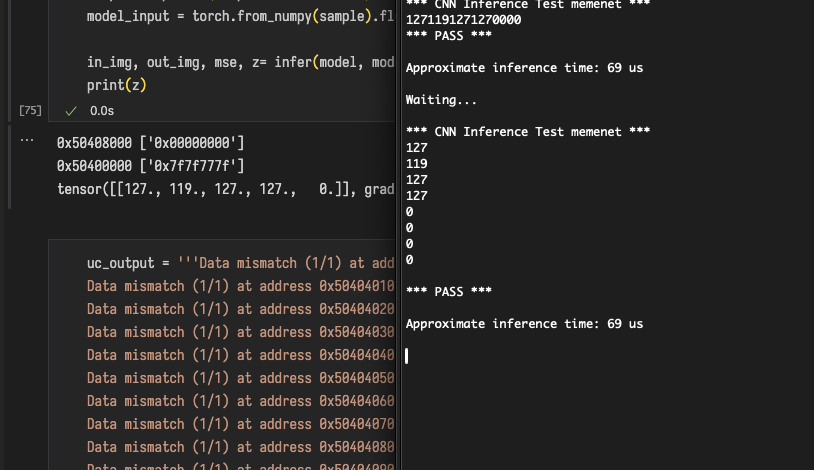

In [ ]:
uc_output = '''Data mismatch (1/1) at address 0x50404000: Expected 0xffffc3b2, read 0xffffb7e2.
Data mismatch (1/1) at address 0x50404010: Expected 0xffffbded, read 0xffffb1d2.
Data mismatch (1/1) at address 0x50404020: Expected 0xffffbc9c, read 0xffffc7fe.
Data mismatch (1/1) at address 0x50404030: Expected 0xffffc1d5, read 0xffffe2f5.
Data mismatch (1/1) at address 0x50404040: Expected 0xffffbdd2, read 0xffffdfd9.
Data mismatch (1/1) at address 0x50404050: Expected 0xffffbefb, read 0xffffdb3b.
Data mismatch (1/1) at address 0x50404060: Expected 0xffffbf12, read 0xffffc487.
Data mismatch (1/1) at address 0x50404070: Expected 0xffffc5cc, read 0xffff994b.
Data mismatch (1/1) at address 0x50404080: Expected 0xffffbea9, read 0xffffa830.
Data mismatch (1/1) at address 0x50404090: Expected 0xffffc12e, read 0xffffafe7.
Data mismatch (1/1) at address 0x504040a0: Expected 0xffffc4c2, read 0xffffa248.
Data mismatch (1/1) at address 0x504040b0: Expected 0xffffb806, read 0xffffae7d.
Data mismatch (1/1) at address 0x504040c0: Expected 0xffffc0ee, read 0xffffd5c3.
Data mismatch (1/1) at address 0x504040d0: Expected 0xffffc513, read 0xffffcca5.
Data mismatch (1/1) at address 0x504040e0: Expected 0xffffc298, read 0xffffe098.
Data mismatch (1/1) at address 0x504040f0: Expected 0xffffc685, read 0xffffe1f6.
Data mismatch (1/1) at address 0x50404100: Expected 0xffffbd5f, read 0xffffa5b8.
Data mismatch (1/1) at address 0x50404110: Expected 0xffffc244, read 0xffffc0a4.
Data mismatch (1/1) at address 0x50404120: Expected 0xffffbbc4, read 0xffffed54.
Data mismatch (1/1) at address 0x50404130: Expected 0xffffbd1a, read 0x00001015.
Data mismatch (1/1) at address 0x50404140: Expected 0xffffc3bd, read 0xfffffaf4.
Data mismatch (1/1) at address 0x50404150: Expected 0xffffbf57, read 0xfffffc45.
Data mismatch (1/1) at address 0x50404160: Expected 0xffffc039, read 0xffff9d3f.
Data mismatch (1/1) at address 0x50404170: Expected 0xffffbdc9, read 0xffff95c9.
Data mismatch (1/1) at address 0x50404180: Expected 0xffffbf2b, read 0xffffb29a.
Data mismatch (1/1) at address 0x50404190: Expected 0xffffbf13, read 0xffffc6af.
Data mismatch (1/1) at address 0x504041a0: Expected 0xffffbd2c, read 0xffff846e.
Data mismatch (1/1) at address 0x504041b0: Expected 0xffffc206, read 0xffffa8bc.
Data mismatch (1/1) at address 0x504041c0: Expected 0xffffb60c, read 0xffffccf1.
Data mismatch (1/1) at address 0x504041d0: Expected 0xffffbddf, read 0xffffdd52.
Data mismatch (1/1) at address 0x504041e0: Expected 0xffffcaea, read 0xffffe10e.
Data mismatch (1/1) at address 0x504041f0: Expected 0xffffbd13, read 0xffffdd75.
Data mismatch (1/1) at address 0x50404200: Expected 0xffffbd81, read 0xffffa0a5.
Data mismatch (1/1) at address 0x50404210: Expected 0xffffc2ba, read 0xffffcfdb.
Data mismatch (1/1) at address 0x50404220: Expected 0xffffc047, read 0xffffe10a.
Data mismatch (1/1) at address 0x50404230: Expected 0xffffbde8, read 0x000001cf.
Data mismatch (1/1) at address 0x50404240: Expected 0xffffbda6, read 0xffffc77b.
Data mismatch (1/1) at address 0x50404250: Expected 0xffffc5e2, read 0xffffd965.
Data mismatch (1/1) at address 0x50404260: Expected 0xffffb966, read 0xffffabaa.
Data mismatch (1/1) at address 0x50404270: Expected 0xffffc10d, read 0xffff89e2.
Data mismatch (1/1) at address 0x50404280: Expected 0xffffbf47, read 0xffffa2c6.
Data mismatch (1/1) at address 0x50404290: Expected 0xffffbb45, read 0xffffc0f4.
Data mismatch (1/1) at address 0x504042a0: Expected 0xffffc63e, read 0xffff8559.
Data mismatch (1/1) at address 0x504042b0: Expected 0xffffbed0, read 0xffffa443.
Data mismatch (1/1) at address 0x504042c0: Expected 0xffffb7ef, read 0xffffcc7e.
Data mismatch (1/1) at address 0x504042d0: Expected 0xffffc291, read 0xffffe8b9.
Data mismatch (1/1) at address 0x504042e0: Expected 0xffffc698, read 0xfffff6a4.
Data mismatch (1/1) at address 0x504042f0: Expected 0xffffbc24, read 0xffffe2af.
Data mismatch (1/1) at address 0x50404300: Expected 0xffffc599, read 0xffffc87b.
Data mismatch (1/1) at address 0x50404310: Expected 0xffffc14a, read 0xfffff6d5.
Data mismatch (1/1) at address 0x50404320: Expected 0xffffc3df, read 0xffffefff.
Data mismatch (1/1) at address 0x50404330: Expected 0xffffc16c, read 0xfffff5fe.
Data mismatch (1/1) at address 0x50404340: Expected 0xffffbb59, read 0xffffae67.
Data mismatch (1/1) at address 0x50404350: Expected 0xffffbb28, read 0xffffc56c.
Data mismatch (1/1) at address 0x50404360: Expected 0xffffc3ba, read 0xffffb596.
Data mismatch (1/1) at address 0x50404370: Expected 0xffffc141, read 0xffff8a3c.
Data mismatch (1/1) at address 0x50404380: Expected 0xffffbebd, read 0xffff8bde.
Data mismatch (1/1) at address 0x50404390: Expected 0xffffbef6, read 0xffffbce5.
Data mismatch (1/1) at address 0x504043a0: Expected 0xffffbd36, read 0xffffb84a.
Data mismatch (1/1) at address 0x504043b0: Expected 0xffffba36, read 0xffffcbc3.
Data mismatch (1/1) at address 0x504043c0: Expected 0xffffc27a, read 0xffffc404.
Data mismatch (1/1) at address 0x504043d0: Expected 0xffffbd42, read 0xffffdf6f.
Data mismatch (1/1) at address 0x504043e0: Expected 0xffffc161, read 0xfffff461.
Data mismatch (1/1) at address 0x504043f0: Expected 0xffffbf75, read 0xffffe5a9.
Data mismatch (1/1) at address 0x50404400: Expected 0xffffc46f, read 0xffffd66a.
Data mismatch (1/1) at address 0x50404410: Expected 0xffffc20d, read 0xfffffad1.
Data mismatch (1/1) at address 0x50404420: Expected 0xffffc4be, read 0xfffffa5a.
Data mismatch (1/1) at address 0x50404430: Expected 0xffffcd4e, read 0x00000b1d.
Data mismatch (1/1) at address 0x50404440: Expected 0xffffbc2c, read 0xfffffa75.
Data mismatch (1/1) at address 0x50404450: Expected 0xffffbb40, read 0x00001ca2.
Data mismatch (1/1) at address 0x50404460: Expected 0xffffbc6f, read 0x000022c9.
Data mismatch (1/1) at address 0x50404470: Expected 0xffffc355, read 0xffffc88d.
Data mismatch (1/1) at address 0x50404480: Expected 0xffffc346, read 0xffffca0b.
Data mismatch (1/1) at address 0x50404490: Expected 0xffffc734, read 0xffffd518.
Data mismatch (1/1) at address 0x504044a0: Expected 0xffffcd5e, read 0xffffcf39.
Data mismatch (1/1) at address 0x504044b0: Expected 0xffffbc8e, read 0xffffea30.
Data mismatch (1/1) at address 0x504044c0: Expected 0xffffc0b4, read 0xfffffa5a.
Data mismatch (1/1) at address 0x504044d0: Expected 0xffffbc84, read 0xfffff80f.
Data mismatch (1/1) at address 0x504044e0: Expected 0xffffbe11, read 0x00000a17.
Data mismatch (1/1) at address 0x504044f0: Expected 0xffffc1d7, read 0xffffdb8e.
Data mismatch (1/1) at address 0x50404500: Expected 0xffffc31d, read 0xffffcf88.
Data mismatch (1/1) at address 0x50404510: Expected 0xffffc1c8, read 0xffffeac4.
Data mismatch (1/1) at address 0x50404520: Expected 0xffffb4fa, read 0xffffe3fe.
Data mismatch (1/1) at address 0x50404530: Expected 0xffffcb68, read 0xfffff701.
Data mismatch (1/1) at address 0x50404540: Expected 0xffffcda5, read 0x00000431.
Data mismatch (1/1) at address 0x50404550: Expected 0xffffc680, read 0x00002bb7.
Data mismatch (1/1) at address 0x50404560: Expected 0xffffcb4b, read 0xffffda0d.
Data mismatch (1/1) at address 0x50404570: Expected 0xffffc93f, read 0xffffa6fe.
Data mismatch (1/1) at address 0x50404580: Expected 0xffffde27, read 0xffffa12c.
Data mismatch (1/1) at address 0x50404590: Expected 0xffffd8d9, read 0xffffa85a.
Data mismatch (1/1) at address 0x504045a0: Expected 0xffffcf88, read 0xffffa35f.
Data mismatch (1/1) at address 0x504045b0: Expected 0xffffc101, read 0xffffb39f.
Data mismatch (1/1) at address 0x504045c0: Expected 0xffffbf23, read 0xfffffbf7.
Data mismatch (1/1) at address 0x504045d0: Expected 0xffffbd88, read 0x00000b6d.
Data mismatch (1/1) at address 0x504045e0: Expected 0xffffc4d3, read 0xfffffb27.
Data mismatch (1/1) at address 0x504045f0: Expected 0xffffca09, read 0xffffd35f.
Data mismatch (1/1) at address 0x50404600: Expected 0xffffbc4a, read 0xffffed76.
Data mismatch (1/1) at address 0x50404610: Expected 0xffffc164, read 0xfffff985.
Data mismatch (1/1) at address 0x50404620: Expected 0xffffbd88, read 0xfffff820.
Data mismatch (1/1) at address 0x50404630: Expected 0xffffb9c0, read 0xffffe36c.
Data mismatch (1/1) at address 0x50404640: Expected 0xffffc4c2, read 0x0000101c.
Data mismatch (1/1) at address 0x50404650: Expected 0xffffc5a2, read 0x0000012c.
Data mismatch (1/1) at address 0x50404660: Expected 0xffffcb79, read 0xffffd668.
Data mismatch (1/1) at address 0x50404670: Expected 0xffffc8a3, read 0xffff9ce0.
Data mismatch (1/1) at address 0x50404680: Expected 0xfffff65c, read 0xffffb8b0.
Data mismatch (1/1) at address 0x50404690: Expected 0xfffffa9e, read 0xffffba95.
Data mismatch (1/1) at address 0x504046a0: Expected 0xfffff25a, read 0xffff9f96.
Data mismatch (1/1) at address 0x504046b0: Expected 0xffffc336, read 0xffffad76.
Data mismatch (1/1) at address 0x504046c0: Expected 0xffffc281, read 0x0000038d.
Data mismatch (1/1) at address 0x504046d0: Expected 0xffffc2e2, read 0x0000313c.
Data mismatch (1/1) at address 0x504046e0: Expected 0xffffc7cb, read 0x000022a4.
Data mismatch (1/1) at address 0x504046f0: Expected 0xffffc681, read 0xffffc580.
Data mismatch (1/1) at address 0x50404700: Expected 0xffffbe02, read 0xffffe0c1.
Data mismatch (1/1) at address 0x50404710: Expected 0xffffbfb5, read 0x0000021f.
Data mismatch (1/1) at address 0x50404720: Expected 0xffffc1a6, read 0xffffc237.
Data mismatch (1/1) at address 0x50404730: Expected 0xffffbe09, read 0xffffd331.
Data mismatch (1/1) at address 0x50404740: Expected 0xffffbb15, read 0xfffff77c.
Data mismatch (1/1) at address 0x50404750: Expected 0xffffc45a, read 0xffffecb6.
Data mismatch (1/1) at address 0x50404760: Expected 0xffffcca7, read 0xffffca9f.
Data mismatch (1/1) at address 0x50404770: Expected 0xffffd12e, read 0xffffd0fe.
Data mismatch (1/1) at address 0x50404780: Expected 0xfffff8fc, read 0xffffaea3.
Data mismatch (1/1) at address 0x50404790: Expected 0x00000429, read 0xffffe3a6.
Data mismatch (1/1) at address 0x504047a0: Expected 0xfffff1c2, read 0xffffcdf4.
Data mismatch (1/1) at address 0x504047b0: Expected 0xffffe08b, read 0xffffd816.
Data mismatch (1/1) at address 0x504047c0: Expected 0xffffc64f, read 0xffffed0f.
Data mismatch (1/1) at address 0x504047d0: Expected 0xffffc738, read 0x00001e63.
Data mismatch (1/1) at address 0x504047e0: Expected 0xffffcb12, read 0xfffffab7.
Data mismatch (1/1) at address 0x504047f0: Expected 0xffffc50a, read 0xffffb1e1.
Data mismatch (1/1) at address 0x50404800: Expected 0xffffc60f, read 0xfffff345.
Data mismatch (1/1) at address 0x50404810: Expected 0xffffbeae, read 0xffffefb2.
Data mismatch (1/1) at address 0x50404820: Expected 0xffffbd7a, read 0xffffb8e2.
Data mismatch (1/1) at address 0x50404830: Expected 0xffffc87f, read 0xffffc7c4.
Data mismatch (1/1) at address 0x50404840: Expected 0xffffb760, read 0xffffd401.
Data mismatch (1/1) at address 0x50404850: Expected 0xffffc152, read 0xffffd352.
Data mismatch (1/1) at address 0x50404860: Expected 0xffffce2a, read 0xffffe41a.
Data mismatch (1/1) at address 0x50404870: Expected 0xffffc9f5, read 0xfffff93a.
Data mismatch (1/1) at address 0x50404880: Expected 0xffffe766, read 0xffffb6b3.
Data mismatch (1/1) at address 0x50404890: Expected 0xfffff494, read 0xffffcac8.
Data mismatch (1/1) at address 0x504048a0: Expected 0xffffeda6, read 0xffffbb8e.
Data mismatch (1/1) at address 0x504048b0: Expected 0xffffe301, read 0xffffc78e.
Data mismatch (1/1) at address 0x504048c0: Expected 0xffffb9a3, read 0xffffb8fc.
Data mismatch (1/1) at address 0x504048d0: Expected 0xffffc02e, read 0xffffc764.
Data mismatch (1/1) at address 0x504048e0: Expected 0xffffbc6a, read 0xffffb34f.
Data mismatch (1/1) at address 0x504048f0: Expected 0xffffb92b, read 0xffffc2d8.
Data mismatch (1/1) at address 0x50404900: Expected 0xffffc09d, read 0xffffc1ed.
Data mismatch (1/1) at address 0x50404910: Expected 0xffffbaa1, read 0xffffc200.
Data mismatch (1/1) at address 0x50404920: Expected 0xffffb9f9, read 0xffffc8d1.
Data mismatch (1/1) at address 0x50404930: Expected 0xffffc694, read 0xffffde9e.
Data mismatch (1/1) at address 0x50404940: Expected 0xffffbaa3, read 0xffffa183.
Data mismatch (1/1) at address 0x50404950: Expected 0xffffc7b1, read 0xffffc9b2.
Data mismatch (1/1) at address 0x50404960: Expected 0xffffc50c, read 0xfffff21d.
Data mismatch (1/1) at address 0x50404970: Expected 0xffffc965, read 0x0000112e.
Data mismatch (1/1) at address 0x50404980: Expected 0xfffff117, read 0xffffbd8b.
Data mismatch (1/1) at address 0x50404990: Expected 0x0000028e, read 0xffffdb33.
Data mismatch (1/1) at address 0x504049a0: Expected 0x00000167, read 0xffffd6fe.
Data mismatch (1/1) at address 0x504049b0: Expected 0xfffff6b9, read 0xffffd742.
Data mismatch (1/1) at address 0x504049c0: Expected 0xffffc3af, read 0xffffdc0f.
Data mismatch (1/1) at address 0x504049d0: Expected 0xffffc9ac, read 0xffffdf24.
Data mismatch (1/1) at address 0x504049e0: Expected 0xffffc2b0, read 0xffffc918.
Data mismatch (1/1) at address 0x504049f0: Expected 0xffffc247, read 0xffffe28d.
Data mismatch (1/1) at address 0x50404a00: Expected 0xffffbe24, read 0xffffafb8.
Data mismatch (1/1) at address 0x50404a10: Expected 0xffffc4b8, read 0xffffdd28.
Data mismatch (1/1) at address 0x50404a20: Expected 0xffffbc1f, read 0xfffff988.
Data mismatch (1/1) at address 0x50404a30: Expected 0xffffbee8, read 0xfffff680.
Data mismatch (1/1) at address 0x50404a40: Expected 0xffffbae9, read 0xffff9097.
Data mismatch (1/1) at address 0x50404a50: Expected 0xffffc3e0, read 0xffffd88f.
Data mismatch (1/1) at address 0x50404a60: Expected 0xffffcc8f, read 0x000019db.
Data mismatch (1/1) at address 0x50404a70: Expected 0xffffc865, read 0x00002c1d.
Data mismatch (1/1) at address 0x50404a80: Expected 0xfffffba0, read 0xfffff386.
Data mismatch (1/1) at address 0x50404a90: Expected 0x0000047f, read 0xffffbb85.
Data mismatch (1/1) at address 0x50404aa0: Expected 0xfffffea1, read 0xffffb934.
Data mismatch (1/1) at address 0x50404ab0: Expected 0xfffffecb, read 0xffffdfd9.
Data mismatch (1/1) at address 0x50404ac0: Expected 0xffffc1a1, read 0xffffeb2e.
Data mismatch (1/1) at address 0x50404ad0: Expected 0xffffc27a, read 0xffffdc7a.
Data mismatch (1/1) at address 0x50404ae0: Expected 0xffffc3df, read 0xffffcc07.
Data mismatch (1/1) at address 0x50404af0: Expected 0xffffc1a4, read 0xffffe95d.
Data mismatch (1/1) at address 0x50404b00: Expected 0xffffc68f, read 0xffff98e4.
Data mismatch (1/1) at address 0x50404b10: Expected 0xffffc36a, read 0xffffb8b5.
Data mismatch (1/1) at address 0x50404b20: Expected 0xffffc025, read 0xfffff703.
Data mismatch (1/1) at address 0x50404b30: Expected 0xffffc40a, read 0x00000aab.
Data mismatch (1/1) at address 0x50404b40: Expected 0xffffc2ca, read 0xffffc8a6.
Data mismatch (1/1) at address 0x50404b50: Expected 0xffffc33c, read 0xffffe4db.
Data mismatch (1/1) at address 0x50404b60: Expected 0xffffc192, read 0xfffff66d.
Data mismatch (1/1) at address 0x50404b70: Expected 0xffffcf1a, read 0x00000a94.
Data mismatch (1/1) at address 0x50404b80: Expected 0x000001be, read 0xffffcd11.
Data mismatch (1/1) at address 0x50404b90: Expected 0x00000b2b, read 0xffffb830.
Data mismatch (1/1) at address 0x50404ba0: Expected 0xfffffd83, read 0xffff9326.
Data mismatch (1/1) at address 0x50404bb0: Expected 0xfffff6d5, read 0xffffcb60.
Data mismatch (1/1) at address 0x50404bc0: Expected 0xffffc98a, read 0xffffd3e4.
Data mismatch (1/1) at address 0x50404bd0: Expected 0xffffc166, read 0xffffce35.
Data mismatch (1/1) at address 0x50404be0: Expected 0xffffca64, read 0xffffe044.
Data mismatch (1/1) at address 0x50404bf0: Expected 0xffffc52a, read 0xffffe629.
Data mismatch (1/1) at address 0x50404c00: Expected 0xffffc08e, read 0xffffa85a.
Data mismatch (1/1) at address 0x50404c10: Expected 0xffffbfb5, read 0xffff845a.
Data mismatch (1/1) at address 0x50404c20: Expected 0xffffc13b, read 0xffffb219.
Data mismatch (1/1) at address 0x50404c30: Expected 0xffffc25e, read 0xffffbc9b.
Data mismatch (1/1) at address 0x50404c40: Expected 0xffffbcdd, read 0xffffa12c.
Data mismatch (1/1) at address 0x50404c50: Expected 0xffffb977, read 0xffffcbf6.
Data mismatch (1/1) at address 0x50404c60: Expected 0xffffbe45, read 0xffffcdae.
Data mismatch (1/1) at address 0x50404c70: Expected 0xffffbc43, read 0xffffd5cf.
Data mismatch (1/1) at address 0x50404c80: Expected 0xfffffbf2, read 0xffffc3a6.
Data mismatch (1/1) at address 0x50404c90: Expected 0x000004db, read 0xffff7d96.
Data mismatch (1/1) at address 0x50404ca0: Expected 0xffffe946, read 0xffff500a.
Data mismatch (1/1) at address 0x50404cb0: Expected 0xffffcd54, read 0xffff918d.
Data mismatch (1/1) at address 0x50404cc0: Expected 0xffffc4fe, read 0xffffa582.
Data mismatch (1/1) at address 0x50404cd0: Expected 0xffffba47, read 0xffffa8c8.
Data mismatch (1/1) at address 0x50404ce0: Expected 0xffffbae7, read 0xffffb99a.
Data mismatch (1/1) at address 0x50404cf0: Expected 0xffffc4ba, read 0xffffe1ef.
Data mismatch (1/1) at address 0x50404d00: Expected 0xffffc057, read 0xffffae6e.
Data mismatch (1/1) at address 0x50404d10: Expected 0xffffc245, read 0xffffad65.
Data mismatch (1/1) at address 0x50404d20: Expected 0xffffbe09, read 0xffffb121.
Data mismatch (1/1) at address 0x50404d30: Expected 0xffffbf5d, read 0xffffaf68.
Data mismatch (1/1) at address 0x50404d40: Expected 0xffffc528, read 0xffffb1aa.
Data mismatch (1/1) at address 0x50404d50: Expected 0xffffc978, read 0xffffc1a7.
Data mismatch (1/1) at address 0x50404d60: Expected 0xffffc161, read 0xffffc00b.
Data mismatch (1/1) at address 0x50404d70: Expected 0xffffbf4f, read 0xffffccf6.
Data mismatch (1/1) at address 0x50404d80: Expected 0xfffff27e, read 0xffffd623.
Data mismatch (1/1) at address 0x50404d90: Expected 0x0000047a, read 0xffffbc82.
Data mismatch (1/1) at address 0x50404da0: Expected 0xffffcd14, read 0xffff88a6.
Data mismatch (1/1) at address 0x50404db0: Expected 0xffffbda2, read 0xffffb964.
Data mismatch (1/1) at address 0x50404dc0: Expected 0xffffc511, read 0xffffac09.
Data mismatch (1/1) at address 0x50404dd0: Expected 0xffffbf24, read 0xffffd2d4.
Data mismatch (1/1) at address 0x50404de0: Expected 0xffffbd41, read 0xffffd312.
Data mismatch (1/1) at address 0x50404df0: Expected 0xffffc90e, read 0xfffff871.
Data mismatch (1/1) at address 0x50404e00: Expected 0xffffc0ca, read 0xffffcea7.
Data mismatch (1/1) at address 0x50404e10: Expected 0xffffbffd, read 0xffffcefc.
Data mismatch (1/1) at address 0x50404e20: Expected 0xffffc05e, read 0xffffe1ed.
Data mismatch (1/1) at address 0x50404e30: Expected 0xffffbd7f, read 0xffffaf8b.
Data mismatch (1/1) at address 0x50404e40: Expected 0xffffbcf0, read 0xffffc34a.
Data mismatch (1/1) at address 0x50404e50: Expected 0xffffc2ac, read 0xffffca8c.
Data mismatch (1/1) at address 0x50404e60: Expected 0xffffc6ba, read 0xffffc557.
Data mismatch (1/1) at address 0x50404e70: Expected 0xffffbf45, read 0xffffcf6e.
Data mismatch (1/1) at address 0x50404e80: Expected 0xfffff66b, read 0xffffe721.
Data mismatch (1/1) at address 0x50404e90: Expected 0x00000c74, read 0xffffe01a.
Data mismatch (1/1) at address 0x50404ea0: Expected 0xffffd6d6, read 0xffffb8f8.
Data mismatch (1/1) at address 0x50404eb0: Expected 0xffffbb97, read 0xffffeff1.
Data mismatch (1/1) at address 0x50404ec0: Expected 0xffffc0d1, read 0xffffe45b.
Data mismatch (1/1) at address 0x50404ed0: Expected 0xffffc81e, read 0xffffec2a.
Data mismatch (1/1) at address 0x50404ee0: Expected 0xffffcc50, read 0xffffd9cd.
Data mismatch (1/1) at address 0x50404ef0: Expected 0xffffcbae, read 0xfffff501.
Data mismatch (1/1) at address 0x50404f00: Expected 0xffffc1e5, read 0xffffde60.
Data mismatch (1/1) at address 0x50404f10: Expected 0xffffc350, read 0xffffd5e7.
Data mismatch (1/1) at address 0x50404f20: Expected 0xffffbbe7, read 0xffffe28a.
Data mismatch (1/1) at address 0x50404f30: Expected 0xffffbd0d, read 0xffffc36c.
Data mismatch (1/1) at address 0x50404f40: Expected 0xffffba39, read 0xffffc950.
Data mismatch (1/1) at address 0x50404f50: Expected 0xffffc800, read 0xffffce8b.
Data mismatch (1/1) at address 0x50404f60: Expected 0xffffc8c3, read 0xffffb647.
Data mismatch (1/1) at address 0x50404f70: Expected 0xffffc50b, read 0xffffdbfd.
Data mismatch (1/1) at address 0x50404f80: Expected 0xffffefbe, read 0xffffd5d7.
Data mismatch (1/1) at address 0x50404f90: Expected 0x000007de, read 0xffffe337.
Data mismatch (1/1) at address 0x50404fa0: Expected 0xffffe540, read 0xffffd4a1.
Data mismatch (1/1) at address 0x50404fb0: Expected 0xffffc96b, read 0x00000e40.
Data mismatch (1/1) at address 0x50404fc0: Expected 0xffffc579, read 0x000004ae.
Data mismatch (1/1) at address 0x50404fd0: Expected 0xffffc9a5, read 0xfffffc28.
Data mismatch (1/1) at address 0x50404fe0: Expected 0xffffca58, read 0xfffff80e.
Data mismatch (1/1) at address 0x50404ff0: Expected 0xffffcfcf, read 0xfffffe87.
'''

'''
  //print all entries of ml_data32
  for (int i = 0; i < CNN_NUM_OUTPUTS; i++) {
    printf("ml_data32[%d] = %d\n", i, ml_data32[i] & 0x000000ff);
  
'''

In [ ]:
img_read = []
img_expected = []
for lines in uc_output.splitlines():
    data = lines.split('read ')[1]
    img_read.append(data.split('.')[0])
    img_expected.append(lines.split('Expected ')[1].split(', read ')[0])

    
print(len(img_read))
print(len(img_expected))
    
#img_read = np.array(img_read).astype(np.uint8).reshape(16, 16)
#img_expected = np.array(img_expected).astype(np.uint8).reshape(16, 16)

img_read = np.array([int(x, 16) for x in img_read]).reshape(16, 16)
img_expected = np.array([int(x, 16) for x in img_expected]).reshape(16, 16)


#plot em
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(img_read, cmap='gray')
plt.title('Read')

plt.subplot(1, 3, 2)
plt.imshow(img_expected, cmap='gray')
plt.title('Expected')

#plot model_output
plt.subplot(1, 3, 3)
plt.title('HValue Output')
plt.imshow(h_values, cmap='gray')
plt.show()


In [ ]:
#histogram of img_read
plt.figure()
plt.hist(img_read.flatten(), bins=10)

#histogram of h_values
plt.figure()
plt.hist(img_expected.flatten(), bins=10)


(img_read < 100).sum()
(img_expected < 100).sum()

